# Загружаем датасеты

In [2]:
import pandas as pd
import json
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score, confusion_matrix, balanced_accuracy_score, roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import random
import matplotlib.pyplot as plt
import joblib

In [23]:
activities_results = pd.read_csv('data_groups.csv')
columns_activities = pd.read_excel('act.xlsx', [0, 1, 2])
holland_results = pd.read_csv('df.csv', sep=';')
users = pd.read_csv('data_users.csv')[['id', 'sex']]
activities_results

,id,activities
0,228725426,"{'Музыкант': 1, 'Городское сообщество': 1, 'Фу..."
1,35218291,{}
2,52276202,"{'Юмор': 48, 'Фитнес': 1, 'Городское сообществ..."
3,57478545,"{'Фотография': 4, 'Туризм, путешествия': 3, 'Ф..."
4,212375829,{}
...,...,...
5503,549755310,"{'Образование': 19, 'Блогер': 16, 'Юмор': 205,..."
5504,253444472,"{'Закрытое сообщество': 1, 'Private group': 1,..."
5505,359535706,{}
5506,370332112,"{'Кино': 7, 'Дополнительное образование': 4, '..."


In [24]:
users['sex'].value_counts()

1    3874
2    1632
0       2
Name: sex, dtype: int64

# Собираем множество всех тематик

In [25]:
columns = set()

for i in range(len(columns_activities)):
  columns |= set(columns_activities[i][columns_activities[i]['is_title'].isna()]['activity'])

columns = sorted(columns)
columns

['DJ',
 'R&B',
 'Rap, Hip-Hop',
 'Авиакомпания',
 'Автовладельцы',
 'Автомобили',
 'Автомойка',
 'Автопроизводитель',
 'Автосалон',
 'Автосервис',
 'Автоспорт',
 'Автострахование',
 'Автотовары',
 'Автошкола',
 'Азартные игры',
 'Активный отдых',
 'Актёр или актриса',
 'Анимация',
 'Антиквариат',
 'Аптека, оптика',
 'Аренда автомобилей',
 'Архив',
 'Астрология, эзотерика',
 'Аэропорт, вокзал',
 'Банк, финансовое учреждение',
 'Баня, сауна',
 'Бар, паб',
 'Баскетбол',
 'Баскетбольная команда',
 'Бассейн',
 'Безопасность',
 'Беременность, роды',
 'Библиотека',
 'Бизнес',
 'Бильярдный клуб',
 'Благотворительная организация',
 'Благотворительность',
 'Блог',
 'Блогер',
 'Блюз',
 'Боевые искусства',
 'Больница',
 'Боулинг',
 'Бухучёт и налоги',
 'Бытовая техника',
 'ВКонтакте',
 'Веб-студия',
 'Ведущий или ведущая',
 'Велосипеды',
 'Ветеринарная клиника',
 'Видеоигра',
 'Видеоигры',
 'Визовый центр',
 'Водный спорт',
 'Водный транспорт',
 'Военное дело',
 'Волейбол',
 'Волейбольная команда'

In [41]:
len(columns)

330

# Получаем таргет в исходном датасете

In [27]:
holland_results = pd.read_csv('df.csv', sep=';')
res_without_id = holland_results.loc[:, ~holland_results.columns.isin(['id', 'max'])]
maximums = []

for i in range(res_without_id.shape[0]):
  M = res_without_id.loc[i][res_without_id.loc[i].where(res_without_id.loc[i] == res_without_id.loc[i].max()).notna()]
  ind = random.randint(0, len(M)-1)
  maximums.append(M.index[ind])

holland_results['max'] = maximums
holland_results

,id,R,I,A,S,E,C,max
0,228725426,8,6,9,9,8,1,A
1,35218291,6,6,10,9,5,5,A
2,52276202,9,11,4,6,4,7,I
3,57478545,6,9,8,3,8,7,I
4,212375829,9,7,9,6,6,4,R
...,...,...,...,...,...,...,...,...
5503,549755310,6,5,6,9,6,10,C
5504,253444472,5,6,9,6,7,9,C
5505,359535706,7,9,4,12,3,7,S
5506,370332112,5,7,6,9,7,8,S


In [28]:
ids_and_max = holland_results[['id', 'max']]
ids_and_max

,id,max
0,228725426,A
1,35218291,A
2,52276202,I
3,57478545,I
4,212375829,R
...,...,...
5503,549755310,C
5504,253444472,C
5505,359535706,S
5506,370332112,S


Проверка сбалансированности классов

In [29]:
ser = ids_and_max['max'].value_counts()
ser = ser[['R', 'I', 'A', 'S', 'E', 'C']]

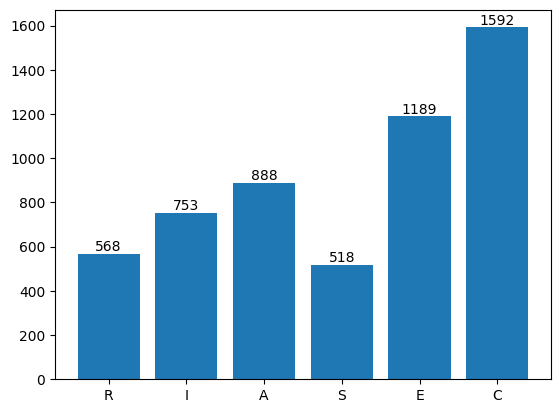

In [30]:
def autolabel(rects, labels=None, height_factor=1.01):

    for i, rect in enumerate(rects):
        height = rect.get_height()

        if labels is not None:

            try:
                label = labels[i]

            except (TypeError, KeyError):
                label = ' '

        else:
            label = '%d' % int(height)
        ax.text(rect.get_x() + rect.get_width()/2., height_factor*height,
                '{}'.format(label),
                ha='center', va='bottom')


fig = plt.bar(ser.index, ser)
ax = plt.gca()
autolabel(ax.patches, height_factor=1)


# Получаем результирующий DataFrame

Собираем строки с id и всеми тематиками

In [ ]:
lines = []

for i in range(activities_results.shape[0]):
  line = []
  j = dict(json.loads(activities_results.loc[i]['activities'].replace("'", '"')))

  for column in columns:
    line.append(j.get(column, 0))

  lines.append(line)
norm_lines = preprocessing.normalize(np.array(lines))

In [33]:
result_df = pd.DataFrame(columns=columns, data=lines)
result_df['id'] = ids_and_max['id']
result_df['sex'] = users['sex']
result_df['target'] = ids_and_max['max']
result_df = result_df.loc[result_df.loc[:, ~result_df.columns.isin(['id', 'target', 'sex'])].sum(axis=1) != 0]
result_df = result_df[result_df['sex'] != 0]
result_df = result_df.reset_index(drop=True)

result_df

,DJ,R&B,"Rap, Hip-Hop",Авиакомпания,Автовладельцы,Автомобили,Автомойка,Автопроизводитель,Автосалон,Автосервис,...,Электроника,Электронная музыка,Эротика,Ювелирные изделия,Юмор,Юридические услуги,Языки,id,sex,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,228725426,2,A
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,48,0,1,52276202,2,I
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,24,0,0,57478545,1,I
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,0,0,10656424,2,E
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,34,0,0,410286883,1,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,0,0,0,0,2,3,0,0,0,0,...,0,0,0,0,6,0,0,14118810,1,I
3496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,10,0,0,316160611,1,C
3497,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,205,0,1,549755310,2,C
3498,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,13,0,0,253444472,1,C


In [34]:
result_df.to_csv('result.csv', index=False)

# Обучение моделек

Считываем собранный датасет

In [35]:
res = pd.read_csv('result.csv')
res

,DJ,R&B,"Rap, Hip-Hop",Авиакомпания,Автовладельцы,Автомобили,Автомойка,Автопроизводитель,Автосалон,Автосервис,...,Электроника,Электронная музыка,Эротика,Ювелирные изделия,Юмор,Юридические услуги,Языки,id,sex,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,228725426,2,A
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,48,0,1,52276202,2,I
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,24,0,0,57478545,1,I
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,0,0,10656424,2,E
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,34,0,0,410286883,1,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,0,0,0,0,2,3,0,0,0,0,...,0,0,0,0,6,0,0,14118810,1,I
3496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,10,0,0,316160611,1,C
3497,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,205,0,1,549755310,2,C
3498,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,13,0,0,253444472,1,C


In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(res.loc[:, ~res.columns.isin(['target', 'id'])], res['target'], test_size=0.2)
X_train

,DJ,R&B,"Rap, Hip-Hop",Авиакомпания,Автовладельцы,Автомобили,Автомойка,Автопроизводитель,Автосалон,Автосервис,...,"Шоу, передача",Экстремальный спорт,Электроника,Электронная музыка,Эротика,Ювелирные изделия,Юмор,Юридические услуги,Языки,sex
2217,0,0,0,0,0,0,0,0,0,0,...,3,0,0,0,0,0,2,0,0,1
1131,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,2,0,0,1
138,0,0,0,0,0,0,0,0,0,0,...,6,0,0,0,0,1,6,0,0,1
1377,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,0,0,1
804,0,0,0,0,1,4,0,0,1,0,...,0,1,0,0,0,0,13,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2909,1,0,3,0,0,1,0,1,0,0,...,2,0,0,4,0,0,6,0,0,2
2799,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,9,0,0,1
2180,3,0,2,0,0,0,0,0,0,0,...,0,0,0,2,0,0,4,0,0,2
898,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,1,24,0,0,2


Скачиваем тестовое множество для gensim

In [30]:
X_test.to_csv('X_test.csv', index=False)

In [ ]:
Y_test.to_csv('Y_test.csv', index=False)

Метрики:

F1-macro:
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

F1-weighted:
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance.

# Decision Tree

In [38]:
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
accuracy = accuracy_score(Y_test, predicted)
f1_macro = f1_score(Y_test, predicted, average = "macro")
f1_weighted = f1_score(Y_test, predicted, average = "weighted")
print(f"accuracy_score: {accuracy}, f1_macro: {f1_macro}, f1_weighted: {f1_weighted}")

accuracy_score: 0.21571428571428572, f1_macro: 0.18193408467306768, f1_weighted: 0.21618459197701773


# Gradient Boosting

In [39]:
model = GradientBoostingClassifier()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
accuracy = accuracy_score(Y_test, predicted)
f1_macro = f1_score(Y_test, predicted, average = "macro")
f1_weighted = f1_score(Y_test, predicted, average = "weighted")
print(f"accuracy_score: {accuracy}, f1_macro: {f1_macro}, f1_weighted: {f1_weighted}")

accuracy_score: 0.34, f1_macro: 0.22181937800285548, f1_weighted: 0.2886263948783593


In [40]:
joblib.dump(model, 'model.pkl')

['model.pkl']

# Logistic Regression

In [28]:
model = LogisticRegression()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
accuracy = accuracy_score(Y_test, predicted)
f1_macro = f1_score(Y_test, predicted, average = "macro")
f1_weighted = f1_score(Y_test, predicted, average = "weighted")
print(f"accuracy_score: {accuracy}, f1_macro: {f1_macro}, f1_weighted: {f1_weighted}")

accuracy_score: 0.2985714285714286, f1_macro: 0.20287554968853314, f1_weighted: 0.26065166749223084


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Gensim Google Model

In [32]:
gensim_result = ['A', 'S', 'A', 'A', 'R', 'A', 'A', 'A', 'I', 'C', 'I', 'C', 'R', 'A', 'R', 'C', 'A', 'R', 'C', 'A', 'C', 'C', 'A', 'R', 'A', 'C', 'C', 'S', 'A', 'R', 'S', 'A', 'S', 'C', 'A', 'R', 'A', 'A', 'I', 'A', 'R', 'S', 'C', 'R', 'I', 'A', 'A', 'A', 'A', 'C', 'C', 'C', 'A', 'C', 'I', 'I', 'A', 'A', 'A', 'E', 'A', 'C', 'I', 'S', 'S', 'A', 'A', 'A', 'A', 'I', 'A', 'A', 'I', 'R', 'A', 'A', 'A', 'I', 'R', 'S', 'E', 'A', 'A', 'R', 'A', 'A', 'C', 'C', 'C', 'S', 'I', 'A', 'I', 'C', 'C', 'R', 'I', 'C', 'A', 'C', 'A', 'A', 'C', 'A', 'C', 'A', 'A', 'A', 'R', 'C', 'A', 'E', 'R', 'R', 'A', 'R', 'R', 'E', 'A', 'A', 'A', 'C', 'C', 'S', 'R', 'A', 'I', 'C', 'I', 'C', 'I', 'A', 'A', 'C', 'C', 'A', 'E', 'I', 'I', 'A', 'I', 'C', 'R', 'C', 'C', 'A', 'A', 'A', 'I', 'A', 'S', 'R', 'R', 'R', 'A', 'S', 'I', 'A', 'R', 'A', 'R', 'R', 'A', 'A', 'A', 'C', 'R', 'C', 'A', 'R', 'S', 'A', 'A', 'A', 'A', 'R', 'I', 'R', 'S', 'R', 'A', 'A', 'E', 'A', 'C', 'A', 'A', 'R', 'A', 'A', 'I', 'I', 'R', 'A', 'C', 'C', 'A', 'A', 'I', 'A', 'C', 'R', 'C', 'R', 'S', 'A', 'E', 'C', 'A', 'R', 'S', 'A', 'I', 'I', 'C', 'A', 'C', 'I', 'A', 'R', 'C', 'R', 'I', 'E', 'I', 'S', 'A', 'C', 'A', 'C', 'C', 'I', 'C', 'A', 'A', 'C', 'A', 'I', 'A', 'A', 'C', 'A', 'A', 'A', 'C', 'R', 'C', 'R', 'A', 'A', 'A', 'C', 'I', 'A', 'A', 'C', 'I', 'C', 'S', 'A', 'I', 'A', 'I', 'A', 'R', 'A', 'A', 'C', 'A', 'A', 'A', 'C', 'I', 'A', 'C', 'R', 'A', 'I', 'C', 'C', 'A', 'A', 'S', 'A', 'A', 'A', 'A', 'R', 'S', 'A', 'C', 'A', 'A', 'I', 'A', 'A', 'C', 'A', 'I', 'C', 'C', 'A', 'A', 'C', 'A', 'S', 'R', 'E', 'A', 'C', 'C', 'A', 'R', 'C', 'A', 'C', 'A', 'A', 'E', 'A', 'E', 'C', 'A', 'C', 'S', 'I', 'C', 'C', 'A', 'A', 'C', 'A', 'C', 'I', 'I', 'R', 'A', 'I', 'E', 'A', 'R', 'R', 'S', 'R', 'R', 'A', 'C', 'E', 'A', 'S', 'A', 'C', 'A', 'R', 'R', 'I', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'I', 'A', 'C', 'A', 'R', 'R', 'A', 'I', 'A', 'C', 'A', 'I', 'C', 'A', 'A', 'E', 'R', 'A', 'I', 'C', 'A', 'A', 'C', 'S', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'S', 'E', 'C', 'C', 'I', 'C', 'R', 'A', 'E', 'A', 'C', 'R', 'A', 'C', 'S', 'A', 'R', 'C', 'I', 'I', 'R', 'A', 'C', 'R', 'A', 'A', 'I', 'C', 'A', 'E', 'C', 'I', 'C', 'A', 'A', 'A', 'I', 'I', 'R', 'R', 'S', 'S', 'E', 'A', 'E', 'C', 'A', 'I', 'A', 'S', 'A', 'S', 'A', 'A', 'I', 'I', 'A', 'I', 'I', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'C', 'S', 'I', 'A', 'A', 'I', 'A', 'A', 'I', 'C', 'I', 'A', 'R', 'S', 'R', 'A', 'A', 'A', 'R', 'E', 'A', 'A', 'R', 'C', 'I', 'E', 'A', 'A', 'S', 'E', 'C', 'A', 'C', 'A', 'R', 'A', 'C', 'C', 'R', 'S', 'A', 'A', 'A', 'A', 'I', 'A', 'R', 'S', 'A', 'S', 'A', 'C', 'A', 'A', 'R', 'R', 'R', 'I', 'R', 'A', 'I', 'R', 'R', 'R', 'I', 'A', 'C', 'A', 'A', 'C', 'C', 'A', 'R', 'A', 'A', 'A', 'A', 'S', 'A', 'C', 'A', 'E', 'C', 'I', 'C', 'C', 'E', 'A', 'A', 'R', 'A', 'A', 'S', 'A', 'A', 'A', 'A', 'A', 'I', 'R', 'R', 'I', 'I', 'I', 'A', 'R', 'I', 'A', 'A', 'C', 'C', 'C', 'R', 'A', 'I', 'E', 'I', 'R', 'I', 'C', 'I', 'A', 'C', 'A', 'A', 'A', 'A', 'A', 'S', 'C', 'C', 'A', 'S', 'C', 'A', 'R', 'S', 'A', 'A', 'C', 'A', 'A', 'I', 'R', 'R', 'A', 'I', 'A', 'A', 'I', 'A', 'E', 'A', 'R', 'C', 'C', 'A', 'A', 'R', 'C', 'A', 'I', 'E', 'I', 'R', 'A', 'A', 'I', 'C', 'C', 'C', 'R', 'S', 'E', 'C', 'A', 'R', 'A', 'A', 'A', 'R', 'R', 'A', 'I', 'A', 'C', 'R', 'A', 'R', 'A', 'A', 'C', 'A', 'R', 'A', 'R', 'R', 'C', 'R', 'A', 'A', 'I', 'S', 'I', 'C', 'C', 'A', 'A', 'C', 'A', 'C', 'I', 'R', 'A', 'A', 'A', 'I', 'A', 'A', 'A', 'C', 'A', 'R', 'A', 'I', 'A', 'A', 'A', 'S', 'S', 'I', 'R', 'R', 'I', 'A', 'I', 'S', 'E', 'R']
accuracy = accuracy_score(Y_test, gensim_result)
f1_macro = f1_score(Y_test, gensim_result, average = "macro")
f1_weighted = f1_score(Y_test, gensim_result, average = "weighted")
print(f"accuracy_score: {accuracy}, f1_macro: {f1_macro}, f1_weighted: {f1_weighted}")

accuracy_score: 0.1757142857142857, f1_macro: 0.1581489459578833, f1_weighted: 0.1691276477831098


# Попробуем кластеризовать тематики

In [35]:
activities = pd.read_excel('activities.xlsx', [0,1,2])
activities

{0:              activity  is_title
 0          Авто, мото       1.0
 1       Автовладельцы       NaN
 2          Автомобили       NaN
 3          Велосипеды       NaN
 4    Водный транспорт       NaN
 ..                ...       ...
 120        Творчество       NaN
 121         Философия       NaN
 122        Фотография       NaN
 123             Языки       NaN
 124           Финансы       2.0
 
 [125 rows x 2 columns],
 1:                activity  is_title
 0            Авто, мото       1.0
 1             Автомойка       NaN
 2     Автопроизводитель       NaN
 3             Автосалон       NaN
 4            Автосервис       NaN
 ..                  ...       ...
 248             Ломбард       NaN
 249     Пенсионный фонд       NaN
 250   Платёжная система       NaN
 251  Страховая компания       NaN
 252    Финансовые рынки       NaN
 
 [253 rows x 2 columns],
 2:                activity  is_title
 0            Авто, мото       1.0
 1             Автомойка       NaN
 2     Автопроиз

In [ ]:
result_dict = {}

for j in activities:
  act = ''

  for i in range(activities[j].shape[0]):

    if activities[j].loc[i]['is_title'] == 1:
      act = activities[j].loc[i]['activity']

    elif activities[j].loc[i]['is_title'] == 2:
      result_dict[activities[j].loc[i]['activity']] = activities[j].loc[i]['activity']

    else:
      result_dict[activities[j].loc[i]['activity']] = act

result_dict['Private group'] = 'Private group'
values = sorted(set(result_dict.values()))

In [ ]:
lines = []

for i in range(activities_results.shape[0]):
  line = []
  j = dict(json.loads(activities_results.loc[i]['activities'].replace("'", '"')))
  act_dict = {}

  for act in j:

    try:
      act_dict[result_dict[act]] = act_dict.get(result_dict[act], 0) + j[act]

    except KeyError:
      continue

  for column in values:
    line.append(act_dict.get(column, 0))

  lines.append(line)

lines

In [66]:
norm_lines = preprocessing.normalize(np.array(lines))

34

In [ ]:
result_df = pd.DataFrame(columns=values, data=lines)
result_df['id'] = ids_and_max['id']
result_df['sex'] = users['sex']
result_df['target'] = ids_and_max['max']
result_df = result_df.loc[result_df.loc[:, ~result_df.columns.isin(['id', 'target', 'sex'])].sum(axis=1) != 0]
result_df = result_df[result_df['sex'] != 0]
result_df = result_df.reset_index(drop=True)

result_df

In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(result_df.loc[:, ~result_df.columns.isin(['target', 'id'])], result_df['target'], test_size=0.2)

# DecisionTreeClassifier

In [69]:
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
accuracy = accuracy_score(Y_test, predicted)
f1_macro = f1_score(Y_test, predicted, average = "macro")
f1_weighted = f1_score(Y_test, predicted, average = "weighted")
print(f"accuracy_score: {accuracy}, f1_macro: {f1_macro}, f1_weighted: {f1_weighted}")

accuracy_score: 0.23142857142857143, f1_macro: 0.20220990214220289, f1_weighted: 0.22900817923236916


# GradientBoostingClassifier

In [70]:
model = GradientBoostingClassifier()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
accuracy = accuracy_score(Y_test, predicted)
f1_macro = f1_score(Y_test, predicted, average = "macro")
f1_weighted = f1_score(Y_test, predicted, average = "weighted")
print(f"accuracy_score: {accuracy}, f1_macro: {f1_macro}, f1_weighted: {f1_weighted}")

accuracy_score: 0.3171428571428571, f1_macro: 0.21790262083054293, f1_weighted: 0.2603064915260048


# LogisticRegression

In [71]:
model = LogisticRegression()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
accuracy = accuracy_score(Y_test, predicted)
f1_macro = f1_score(Y_test, predicted, average = "macro")
f1_weighted = f1_score(Y_test, predicted, average = "weighted")
print(f"accuracy_score: {accuracy}, f1_macro: {f1_macro}, f1_weighted: {f1_weighted}")

accuracy_score: 0.2842857142857143, f1_macro: 0.13211646226303123, f1_weighted: 0.17558821069585323


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
